In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [23]:
from models.Wang2020 import M4
net = M4(N_layers=8, width=32, alpha=0.9).to(device)

In [20]:
import os
from utils.dataset import ImplicitDataset

dataset_name = '../datasets/box_1.0_10K_1M'
output_stl = dataset_name+'.stl'
train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
print(train_dataset)

Implicit dataset (15344 PDE points, 4384 Dirichlet BCs)
MeshSDFDataset (1000000 points)


In [24]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
optimizer=torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.init_LBFGS(
        lr=1, max_iter=20, max_eval=40, 
        tolerance_grad=1e-5, tolerance_change=1e-9,
        history_size=100,
        line_search_fn=None
    ),
    CallbackScheduler.reduce_lr(0.2)
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [25]:
#torch.autograd.set_detect_anomaly(True)
max_epochs = 2500
PRINT_EVERY_EPOCH = 100
try:
    for epoch in range(max_epochs):
        # Training
        optimizer.zero_grad()
        loss = net.loss(train_dataset.pde_points, train_dataset.bc_points, train_dataset.bc_sdfs)
        loss.backward()
      
        lr_scheduler.optimizer.step(lambda: loss)
        lr_scheduler.step_when((epoch % 500) == 499)
        lr_scheduler.step_loss(loss)
        
        if (epoch % 10) == 0:
            net.adaptive_lambda(train_dataset.pde_points, train_dataset.bc_points, train_dataset.bc_sdfs)

        if epoch % PRINT_EVERY_EPOCH == 0:
            print(f'#{epoch} Loss: {net._loss_PDE:.6f}, {net._loss_SDF:.6f}, {net.loss_lambda[0]:.6f}')
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 0.516234, 0.089220, 11.638404
#100 Loss: 0.098102, 0.002864, 1783.105288
#200 Loss: 0.060217, 0.000246, 2677.910834
#300 Loss: 0.049861, 0.000253, 4904.528601
#400 Loss: 0.045891, 0.000116, 8885.659243
#500 Loss: 0.041261, 0.000086, 9323.188400
#600 Loss: 0.040172, 0.000079, 54949.096431
Bye bye


SDF: min = -0.526157	max = 0.712359


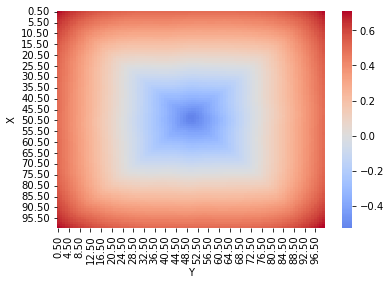

Gradient: min = 0.322934	max = 1.361797


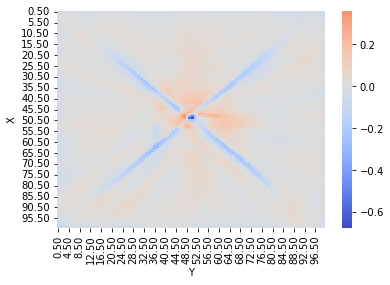

Gradient 2: min = 0.014319	max = 37.910013


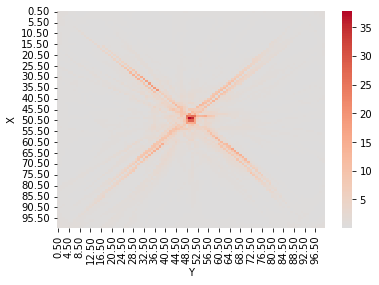

SDF: min = -0.491869	max = 0.710387


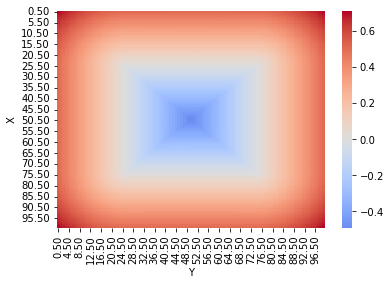

Gradient: min = 0.692830	max = 1.062796


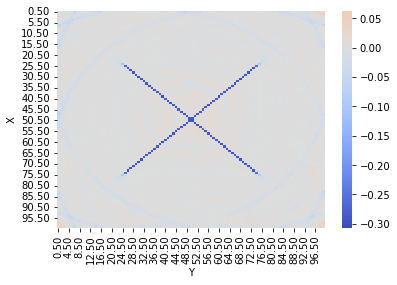

Gradient 2: min = 0.000865	max = 10.754922


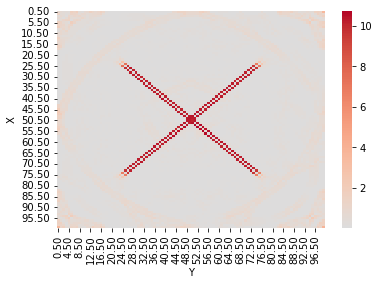

In [34]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0, step=0.05, offset=30, nums=100)
visualize.from_nn(net, bounds_from_mesh=output_stl, device=device, plot_gradient=True)
visualize.from_mesh(output_stl, plot_gradient=True)